In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, LayerNormalization
from keras.optimizers import Adam, SGD
import keras.backend as K
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import sklearn.linear_model
import sklearn.preprocessing

In [87]:
def MeanPositiveError(truth, prediction):
    error = truth - prediction
    error = error[error >= 0]
    return np.sum(error)/np.shape(truth)[0]

def keras_mpe(y_true, y_pred):
    error = (y_true - y_pred)
    positive_error = K.sum(error[K.greater_equal(error, 0)])
    negative_error = K.sum(K.sqrt(K.abs(error[K.greater_equal(0.0, error)])))
    
    return 2 * positive_error + negative_error

## Zip Predictor

In [116]:
# Import decompression size .csv
zip_results_df = pd.read_csv("../data/zip_decompression_results.csv")

x = np.array(zip_results_df.compressed_size)
y = np.array(zip_results_df.decompressed_size)

In [117]:
# Train sklearn model
zip_sklearn_model = sklearn.linear_model.LinearRegression()
zip_sklearn_model.fit(x.reshape(-1, 1), y)

y_pred = zip_sklearn_model.predict(x.reshape(-1, 1))

print(f"Line: {zip_sklearn_model.coef_}x + {zip_sklearn_model.intercept_}")
print(f"R^2: {zip_sklearn_model.score(x.reshape(-1, 1), y)}")
print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred)}")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred))}")
print(f"MPE: {MeanPositiveError(y, y_pred)}")

Line: [5.88836066]x + -21122719.688942432
R^2: 0.4114918533032038
MSE: 1.3310794749774374e+18
RMSE: 1153724176.2992737
MPE: 124010328.56158382


In [118]:
# Train keras model

x_sc = sklearn.preprocessing.StandardScaler()
y_sc = sklearn.preprocessing.StandardScaler()
x_scaled = x_sc.fit_transform(x.reshape(-1, 1)).flatten()
y_scaled = y_sc.fit_transform(y.reshape(-1, 1)).flatten()

adam = Adam(lr=0.01)
sgd = SGD(lr=0.01)

zip_keras_model = Sequential()
zip_keras_model.add(Input((1,)))
zip_keras_model.add(Dense(1, activation="linear", use_bias=False))
zip_keras_model.compile(optimizer=sgd, loss=keras_mpe)

zip_keras_model.summary()

history = zip_keras_model.fit(x_scaled, y_scaled,
                              epochs=100)

y_pred = y_sc.inverse_transform(zip_keras_model.predict(x_scaled).reshape(-1, 1)).flatten()

print(f"MSE: {sklearn.metrics.mean_squared_error(y, y_pred) / (10 ** 9)}GB")
print(f"RMSE: {np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred)) / (10 ** 9)}GB")
print(f"MPE: {MeanPositiveError(y, y_pred) / (10 ** 9)}GB")

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
53/53 [==============================] - 0s 478us/step - loss: 11.3104
Epoch 2/100
53/53 [==============================] - 0s 471us/step - loss: 9.6986
Epoch 3/100
53/53 [==============================] - 0s 475us/step - loss: 9.7367
Epoch 4/100
53/53 [==============================] - 0s 452us/step - loss: 10.1198
Epoch 5/100
53/53 [==============================] - 0s 474us/step - loss: 12.4743
Epoch 6/100
53/53 [==============================] - 0s 499us/step - loss: 10.3936
Epoch 7/100
53/53 [==============================] - 0s 507us/step - loss: 17.7107
Epoch 8/100
53/53 [==============================] - 0s 467us/step - loss:

53/53 [==============================] - 0s 481us/step - loss: 11.0135
Epoch 94/100
53/53 [==============================] - 0s 442us/step - loss: 11.5009
Epoch 95/100
53/53 [==============================] - 0s 476us/step - loss: 10.5530
Epoch 96/100
53/53 [==============================] - 0s 433us/step - loss: 12.7054
Epoch 97/100
53/53 [==============================] - 0s 459us/step - loss: 8.6298
Epoch 98/100
53/53 [==============================] - 0s 435us/step - loss: 13.1196
Epoch 99/100
53/53 [==============================] - 0s 478us/step - loss: 10.5255
Epoch 100/100
53/53 [==============================] - 0s 427us/step - loss: 13.3515
MSE: 1335119748.646433GB
RMSE: 1.1554738199744867GB
MPE: 0.1166906548746066GB


In [119]:
def zip_keras_predict(x):
    x_scaled = x_sc.transform(x)
    return y_sc.inverse_transform(zip_keras_model.predict(x_scaled).reshape(-1, 1)).flatten()

Text(0, 0.5, 'Decompressed size (bytes)')

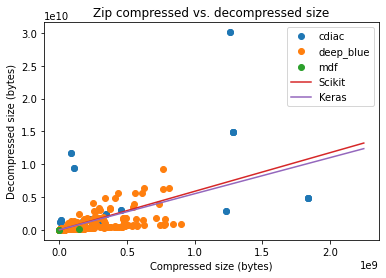

In [120]:
# Visualize compression vs. decompression
x1 = zip_results_df.compressed_size
y1 = zip_results_df.decompressed_size

# Figure 1
for name, group in zip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
         zip_sklearn_model.predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Scikit")

plt.plot(np.array([i for i in range(1, 25*10**8, 25*10**7)]), 
         zip_keras_predict(np.array([i for i in range(1, 25*10**8, 25*10**7)]).reshape(-1, 1)), 
         label="Keras")

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")